In this notebook, we will be recreating the analysis made in https://doi.org/10.1038/s41550-020-01295-8 by Stein et al. The data and their code is aviable in his GitHub.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from datetime import date

#gamma function and integration
from scipy import special, optimize
from scipy import integrate


#Fitting the spectrum
from scipy.optimize import curve_fit


#Using csv tables
import pandas as pd

#Astropy module to handle units
import astropy
from astropy.io import ascii
from astropy import units as u
from astropy.units import Quantity
from astropy import constants as const

#Importing the constant that will be needed
from astropy.constants import c, k_B, m_e, e

First, let's get the data that will be fitted.

In [11]:
data_rec = astropy.io.ascii.read(os.path.join("Data/", 'at2019dsg_merged.dat'), format='fixed_width')
data_rec.colnames

['date', 'mjd', 'nu_GHz', 'inst', 'flux_mJy', 'eflux_mJy']

Quick function to convert dates to days since the detection.

In [3]:
def DaysSinceDetection(date_string):
    """
    Returns the days since the optical detection of the source AT2019dsg  (2019 April 1) given a date (string) in format 
    2019/04/01
    Parameters
    :date: Date that want to be converted

    Output
    :days:
    """
    splitted=date_string.split('/')
    date_converted= date(2000+int(splitted[0]), int(splitted[1]), int(splitted[2]))
    date0= date(2019, 4, 1)
    days= date_converted - date0
    return days.days

Let's make a plot to visualize the data.

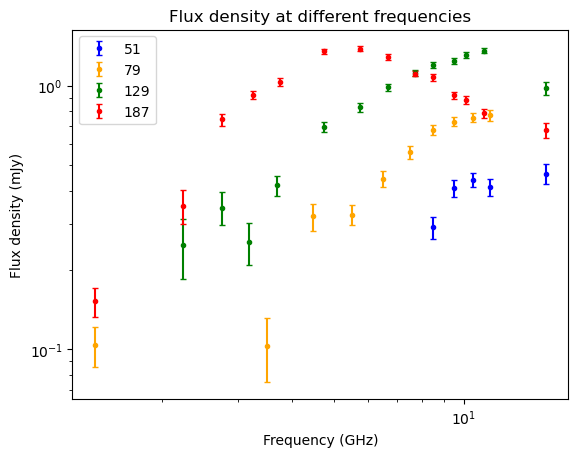

In [140]:
#Array with the dates
list_dates= set(data_rec['date'])
date_list=[[[], [], []], [[], [], []], [[], [], []], [[], [], []]]

for data in data_rec:
    if data['date']== '19/05/22' or data['date']== '19/05/21':
        date_list[0][0].append(data['nu_GHz'])
        date_list[0][1].append(data['flux_mJy'])
        date_list[0][2].append(data['eflux_mJy'])
    if data['date']== '19/06/19':
        date_list[1][0].append(data['nu_GHz'])
        date_list[1][1].append(data['flux_mJy'])
        date_list[1][2].append(data['eflux_mJy'])
    if data['date']== '19/08/08' or  data['date']== '19/08/07':
        date_list[2][0].append(data['nu_GHz'])
        date_list[2][1].append(data['flux_mJy'])
        date_list[2][2].append(data['eflux_mJy'])
    if data['date']== '19/10/05':
        date_list[3][0].append(data['nu_GHz'])
        date_list[3][1].append(data['flux_mJy'])
        date_list[3][2].append(data['eflux_mJy'])
        
#First optical detection was 2019 april 9

plt.errorbar(date_list[0][0], date_list[0][1], yerr=  date_list[0][2],fmt= '.',capsize= 2 , c='blue',
             zorder=8, label=str(DaysSinceDetection('19/05/22')))
plt.errorbar(date_list[1][0], date_list[1][1], yerr=  date_list[1][2],fmt= '.',capsize= 2 , c='orange',
             zorder=8, label=str(DaysSinceDetection('19/06/19')))
plt.errorbar(date_list[2][0], date_list[2][1], yerr=  date_list[2][2],fmt= '.',capsize= 2 , c='green',
             zorder=8, label=str(DaysSinceDetection('19/08/08')))
plt.errorbar(date_list[3][0], date_list[3][1], yerr=  date_list[3][2],fmt= '.',capsize= 2 , c='red',
             zorder=8, label=str(DaysSinceDetection('19/10/05')))
     

plt.yscale('log')
plt.xscale('log')
plt.xlabel(f"Frequency (GHz)")
plt.ylabel(f'Flux density (mJy)')
plt.title('Flux density at different frequencies')
plt.legend()
plt.show()

Now we will be defining the model to fit the data. They assume that the flux comes from 2 conical volumes with $\phi=30\degree$ so the covering factors are $f_A=1 - cos\phi=0.13$ and $f_V=2/(3tan\phi)=1.15$. The free parameters are the electron power-law index (p= 2.9 ± 0.1) and the host baseline flux density, plus the magnetic field and radius for 
each epoch. So we just have a syncrotron emission previusly studied here, with no model of the time evolution for R and B so they are free parameters at each time. (NO SERIA NECESARIO TAMBIEN METER EL N COMO PARAMTRO EN ESTE CASO? ---> CREO QUE ESTAN RELACIONADOS POR PRINCIPIOS DE EQUIPARTICIÓN IMPLEMENTARLO TAMBIEN)

# 1. Synchrotron functions

In [5]:
#Defininf Pacholcyzk's constants
c1=(const.e.esu*3/(4*np.pi*const.m_e.cgs**3*const.c.cgs**5)).cgs.value

c3=(const.e.esu**3*np.sqrt(3)/(4*np.pi*const.m_e.cgs*const.c.cgs**2)).cgs.value

def Pacholcyzk5(p):
    """
    Pacholcyzk5 returns the value of the Pacholcyzk c5 constant given p
    Parameters
    :p: Coefficient of the power law defining the electron population

    Output
    :c5: Value of the constant
    """
    c5=3**0.5/(16*np.pi)*(const.e.esu**3/(const.m_e*const.c**2))*(p+7/3)/(p+1)*scipy.special.gamma((3*p-1)/12)*scipy.special.gamma((3*p+7)/12)
    #return only the value in cgs units to make possible a fit
    return c5.cgs.value
    
def Pacholcyzk6(p):
    """
    Pacholcyzk6 returns the value of the Pacholcyzk c6 constant given p
    Parameters
    :p: Coefficient of the power law defining the electron population

    Output
    :c6: Value of the constant
    """
    c6=np.pi*3**0.5/(72)*const.e.esu*const.m_e**5*const.c**10*(p+10/3)*scipy.special.gamma((3*p+2)/12)*scipy.special.gamma((3*p+10)/12)
    return c6.cgs.value

In [116]:
def SynchrotronEmissionCoeff(p, B, N0, frequency):
    """
    Returns the emission coefficient for a synchrotron emisison of a population of relativistic electrons

    Parameters
    :p: Coefficient of the power law defining the electron population
    :B: Magnetic field
    :N0: Constant of the power law
    :frequency: frequency at which the emission coefficient want to be calculated

    Output
    :EmissionCoeff: Emission coefficient value
    """

    EmissionCoeff=Pacholcyzk5(p)*N0*B**((p+1)/2)*(frequency/(2*c1))**((1-p)/2)
    return EmissionCoeff

def SynchrotronAbsorptionCoeff(p, B, N0, frequency):
    """
    Returns the absorption coefficient for a synchrotron population of relativistic electrons

    Parameters
    :p: Coefficient of the power law defining the electron population
    :B: Magnetic field
    :N0: Constant of the power law
    :frequency: frequency at which the absorption coefficient want to be calculated

    Output
    :AbsorptionCoeff: absorption coefficient value
    """

    AbsorptionCoeff=Pacholcyzk6(p)*N0*B**((p+2)/2)*(frequency/(2*c1))**(-(p+4)/2)
    return AbsorptionCoeff

def SourceFuncSynch(p, B, N0, frequency):
    """
    returns the value of the source function for a given frequency

    Parameters
    :p: Exponent of the power law of electron population
    :B: Value of the magnetic field
    :N0: Constant of the power law
    :Ne: Thermal electron number density
    :Te: Temperature of the electrons
    :frequency: frequency at which the source function want to be calculated
    
    Output
    :S: Value of the source function at the given frequency
    """

    S=SynchrotronEmissionCoeff(p, B, N0, frequency)/(SynchrotronAbsorptionCoeff(p, B, N0, frequency))
    return S


def SpecIntSynch(p, B, N, radius, frequency):
    """
    SpecIntSynch returns the specific intensity of a population of relativistic electrons driven by a power law at a given
    frequency

    Paramenters
    :p: exponent of the power law
    :B: Magnetic field
    :N: Constant of the power law
    :radius: Radius of the emiting region
    :frequency: frequency at which the specific intensity is computed

    Output
    :I: specific intensity at the given frequency
    """

    S = SourceFuncSynch(p, B, N, frequency)
    kappa= SynchrotronAbsorptionCoeff(p, B, N, frequency)
    
    I=S*(1 - np.exp(-radius*kappa))
    return I

def solidangle(radius, distance):
    """
    solidangle gives the solid angle of a source at distance d and size r in the small angle approximation.If units are 
    desired at the output, they must be inserted in the parameters with unit module

    Parameters
    :radius: radius of the source
    :distance: distance from Earth to source

    Outputs
    :omega: solid angle of the source
    """
    #Applying the expresion for the solid angle in the small angle approximation
    omega= np.pi * (radius**2)/(distance**2)
    return omega

def FluxatTSynch(frequency, r, p, B, N, distance, F0, alpha):
    """
    Flux returns the value of the flux foor a population of relativistic electrons driven by a power law at a given frequency

    Parameters
    :frequency: frequency at which the specific intensity is computed
    :p: exponent of the power law describing electron population
    :B: Magnetic field at the epoch
    :N: Constant of the power law at the epoch
    :distance: Distance to the source
    :F0: Steady radio emission from the host galaxy+
    :alpha: Base flux of the hsot galaxy power law exponent
    
    Output
    :F: Flux of the source
    """
    Fbase= F0*(frequency/1.28e9)**(alpha)
    
    F=Fbase + solidangle(r, distance)*SpecIntSynch(p, B, N, r, frequency)*1e23*1e3 # to convert to cgs units
    return F #In order to get from cgs to Jy


In [23]:
def freqtowavelenght(frequency):
    """
    Transforms from frequency to wavelenght

    Parameters
    :frequency: Input frequency

    Output
    :wavelenght:
    """
    frequency=frequency.to(u.Hz)
    return (const.c/frequency).decompose()

def wavelenghttofreq(wavelenght):
    """
    Transforms from wavelenght to frequency

    Parameters
    :wavelenght: Input wavelenght

    Output
    :frequency:
    """
    wavelenght=wavelenght.to(u.m)
    return (const.c/wavelenght).decompose()

# 2. Fit to the data

Lets find by hand the order of the fit parameters.

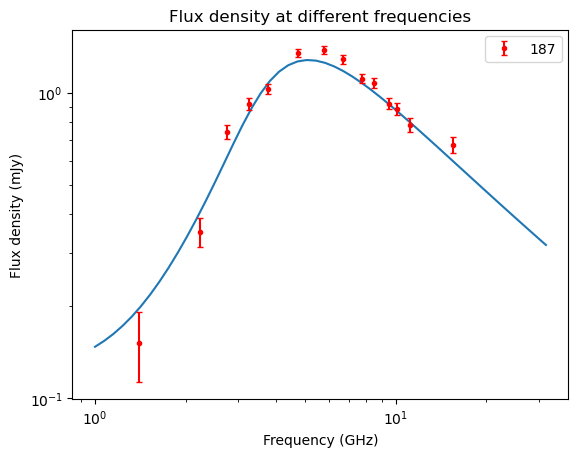

In [136]:
#Input parameters
freqcont= np.logspace(0, 1.5, base=10) #In mHz
distance= ((214*u.Mpc).to(u.cm)).value # http://astro.vaporia.com/start/at2019dsg.html

p=3.
F0= 1e-1
alpha= -0.2

B= (0.2*u.G).value
N= (0.9e-8*u.cm**(-3)).value
R= (7e16*u.cm).value


F= FluxatTSynch(freqcont*1e9 , R, p, B, N, distance, F0, alpha)

plt.plot(freqcont, F)
plt.errorbar(date_list[3][0], date_list[3][1], yerr= data['eflux_mJy'],fmt= '.',capsize= 2 , c='red',
             zorder=8, label=str(DaysSinceDetection('19/10/05')))
     

plt.yscale('log')
plt.xscale('log')
plt.xlabel(f"Frequency (GHz)")
plt.ylabel(f'Flux density (mJy)')
plt.title('Flux density at different frequencies')
plt.legend()
plt.show()

Now lets make a multi frequency and multi time fit.

In [215]:
def leastsq_function(params, *args):
    """
    
    """
    #Time independent parameters
    p = params[0]
    F0 = params[1]
    alpha= params[2]
    
    #Time dependent pàrameters
    B = params[3]
    R= params[4]
    N = params[5]

    #Arguments
    frequency = args[0]
    distance = args[1]
    FluxValue= args[2]
    FLuxErr= args[3]

    sum=0
    #Fit each time
    for i in np.arange(0, len(FluxValue)):
        for j in np.arange(0, len(frequency[i])):
            FLuxFit= FluxatTSynch(frequency[i][j]*1e9 , R[i], p[1], B[i], N[i], distance, F0[1], alpha[1])
            sum= sum + np.abs(FluxValue[i][j] - FluxFit)
            
    return sum

In [216]:
#Input parameters
freqcont= np.logspace(0, 1.5, base=10) #In mHz
freq = []
FluxValue = []
FluxErr = []
distance= ((214*u.Mpc).to(u.cm)).value # http://astro.vaporia.com/start/at2019dsg.html

for time in date_list:
    freq.append(time[0])
    FluxValue.append(time[1])
    FluxErr.append(time[2])

p=3.*np.ones(len(date_list))
F0= 1e-1 *np.ones(len(date_list))
alpha= -0.2 *np.ones(len(date_list))

B= (0.2*u.G).value*np.ones(len(date_list))
N= (0.9e-8*u.cm**(-3)).value*np.ones(len(date_list))
R= (7e16*u.cm).value*np.ones(len(date_list))

params0=(p, F0, alpha, B, R, N)
params= np.ndarray((6, len(date_list)))
for i in np.arange(0, len(params0)):
    params[i]= params0[i]
args0=(freq, distance, FluxValue, FluxErr)

result = scipy.optimize.leastsq(leastsq_function, x0 = params, args=args0)

IndexError: invalid index to scalar variable.

In [218]:
freq[1]

[11.511,
 9.511001,
 8.487001,
 7.511001,
 6.487001,
 5.511001,
 4.487001,
 3.499001,
 10.487,
 1.4]